# Purpose

The goal of this notebook is to 
1. document the process leading to the decisions made in 2023_openfield.py including using the classifiers and documenting their utility.
2. Allow for modifications in the analysis of individual files if the automatic analyses fail.

# Imports

In [156]:
import numpy as np
import pandas as pd
import glob, os, csv, cv2, math, itertools, warnings, joblib
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import tree
from scipy.io import arff

In [6]:
def reformat_df(df,likelihood_val,max_px_value,frame_limit_val,seconds,fps):
    """ this function takes a dataframe containing the data from DeepLabCut 
    predictions on a video and some user inputs to remove data that doesn't meet a
    likelihood threshold (user input) and also exclude large jumps from the data, 
    based on max_px_value user input. Finally, it smooths the data using additional
    user inputs. 
    
    INPUTS:
    1. df - a pandas dataframe object
    2. likelihood_val - a float, typically .9, which is used to remove (fill with nans)
    any data which doesn't meet this criteria/confidence from DLC prediction
    3. max_px_value - an integer, that dictates how far away in pixels a point can be 
    without being discarded as an outlier (e.g. if the nose is annotated at 0,0 at time=0 and the
    max_px_value is 100, if at time=1 the value is 0,101 that value would be replaced with nan
    4. frame_limit_val - an integer that says over how many frames we interpolate between for 
    labeled animal points. e.g. if the nose was visible at frame 0 and frame 2, but had low confidence
    and was therefore removed for frame 1, the nose was likely present in frame 1, and lies somewhere
    between points 0 and 2. A frame_limit_val of 2 or more would allow this to be 'filled in' by
    interpolation. If frame_limit_val is set to 0 or 1, no interpolation occurs.
    5. seconds - an integer that says over how many seconds we take the median value for each
    data point of BOX VALUES ONLY. This is used to remove discontinuities.
    6. fps- a float representing the framerate of the video that DLC was run on, typically 29.93)
    
    OUTPUTS: a pandas dataframe object with the smoothed, high-confidence data from the DLC points
    """
    new_df=pd.DataFrame()
    cols = np.unique([col[0] for col in df.columns])
    for col in cols:
        print(col)
        if "bodyparts" not in col:
            part = df[col]
            for idx in np.arange(0,len(part.x)):
                if idx%100==0:
                    print('on {} of {}'.format(idx,len(part.x)))
                if part.likelihood[idx] < likelihood_val:
                    part.x[idx] = np.nan
                    part.y[idx] = np.nan
                second_idx = np.max([0,idx-1])
                if abs(part.y[idx]-part.y[second_idx]) > max_px_value:
                    part[idx] = np.nan
                elif abs(part.x[idx]-part.x[second_idx]) > max_px_value:
                    part.x[idx] = np.nan

            if "box" not in col and "opening" not in col and "bodyparts" not in col:
                part.x = part.x.interpolate(limit=frame_limit_val)
                part.y = part.y.interpolate(limit=frame_limit_val)
                new_part = pd.concat({col:part},axis=1)
                if col == cols[1]:
                    new_df=new_part
                else:
                    new_df = pd.concat([new_df,new_part],axis=1)
            else:
                print('interp x')
                part.x = part.x.interpolate()
                print('roll x')
                part.x=part.x.rolling(seconds*fps,min_periods=1).median()
                print('interp y')
                part.y = part.y.interpolate()
                print('roll y')
                part.y=part.y.rolling(seconds*fps,min_periods=1).median()
                new_location = pd.concat({col:part},axis=1)
                new_df=pd.concat([new_df,new_location],axis=1)
            
    return new_df

In [5]:
def align_df(df):
    """this function takes the processed DLC data and puts all labeled points in "mm space", such
    that the corners of the box are at 0,0 0,500, 500,500 and 500,0.
    
    INPUTS: a data frame containing smoothed, high-confidence DLC data
    
    OUTPUTS: a pandas dataframe object, after adjusting all location points to mm space, 
    rather than pixel space
    """
    new_df=pd.DataFrame()
    # for each index, get the box coords, find transformation matrix, then apply it to all other points
    s1=[0,500]
    s2=[500,500]
    s3=[0,0]
    s4=[500,0]
    for idx in np.arange(0,len(df)):
        if idx%1000==0:
            print('at {} of {} rows'.format(idx,len(df)))
        # get box points
        p1=[df.box_bl.x[idx],df.box_bl.y[idx]] #0,500
        p2=[df.box_br.x[idx],df.box_br.y[idx]] #500,500
        p3=[df.box_tl.x[idx],df.box_tl.y[idx]] #0,0
        p4=[df.box_tr.x[idx],df.box_tr.y[idx]] #500,0
        # get transform matrix
        M = cv2.getPerspectiveTransform(np.float32([p1,p2,p3,p4]),np.float32([s1,s2,s3,s4]))
        # apply transform matrix to other points
        sub_df=df[df.index==idx].copy()
        for i in np.arange(0,len(sub_df.columns),3):
            p1_0=sub_df.iloc[0,i]
            p1_1=sub_df.iloc[0,i+1]
            if np.isnan(p1_0):
                p1_0_new=np.nan
                p1_1_new=np.nan
            else:
                # set points
                pts = np.array([[[p1_0,p1_1]]],dtype='float32')
                # use transform matrix to un-warp the points
                [p1_0_new,p1_1_new]=cv2.perspectiveTransform(pts,M)[0][0]
            sub_df.iloc[0,i]=p1_0_new
            sub_df.iloc[0,i+1]=p1_1_new
        new_df=pd.concat([new_df,sub_df],axis=0)
    return new_df

# User inputs

In [137]:
FPS=29.93 #frames per second of the video, typically 29.93
#filename='../data/' # full path to the DLC file you'd like to work on
# TODO change to include an example in file structure
filename = '../../../AlexF/VID_20210923_095848DLC_resnet50_2022_Knowles_AlexOct13shuffle1_250000.csv'
trained_file = '../data/20230305_RF_jumps_rears.pkl'

# Procedure for working with a particular file

In [152]:
sub_file_name=filename.split('/')[-1][0:19]
print(sub_file_name) #this is the subfilename

VID_20210923_095848


In [8]:
# read in the file and look at it
df = pd.read_csv(filename,header=[1,2])
df

bodyparts     box_tl                             box_tr              \
         coords          x           y likelihood           x           y   
0             0  78.819817  461.348145   0.970968  895.608154  460.175903   
1             1  78.601166  460.338043   0.976126  894.918335  451.181183   
2             2  78.611977  460.760193   0.975728  895.720398  453.220062   
3             3  78.432205  460.769501   0.976130  893.484009  452.182007   
4             4  78.250450  460.439362   0.974672  893.203796  451.155365   
...         ...        ...         ...        ...         ...         ...   
26123     26123  25.197023  442.650330   0.987113  850.037415  448.896881   
26124     26124  26.455959  450.938568   0.995291  849.300293  461.070038   
26125     26125  25.358833  461.889465   0.982853  850.723206  461.125427   
26126     26126  25.768799  452.744446   0.996038  849.409973  454.769073   
26127     26127  23.965715  453.338135   0.996988  846.185303  464.716827   

                     box_bl                          ... paw_left_front  \
      likelihood          x            y likelihood  ...     likelihood   
0       0.936854  88.904381  1277.683350   0.969771  ...       0.100103   
1       0.968237  89.831520  1276.500366   0.963116  ...       0.091402   
2       0.970130  88.979301  1277.920532   0.956444  ...       0.097281   
3       0.962500  89.107292  1277.541504   0.948494  ...       0.095171   
4       0.970290  89.228752  1277.096313   0.956997  ...       0.079965   
...          ...        ...          ...        ...  ...            ...   
26123   0.970369  33.410820  1275.276733   0.993680  ...       0.060968   
26124   0.970369  33.526249  1281.663330   0.995488  ...       0.084228   
26125   0.935868  32.897385  1294.209595   0.991728  ...       0.067122   
26126   0.958785  33.516560  1283.969971   0.995386  ...       0.096544   
26127   0.961875  32.373833  1284.886108   0.992853  ...       0.073795   

      paw_right_front                         paw_left_back               \
                    x            y likelihood             x            y   
0          439.367218  1278.743896   0.088786    442.540680  1280.387207   
1          440.793304  1274.392944   0.064021    445.773712  1276.296631   
2          440.279205  1274.850708   0.071854    445.519928  1276.581665   
3          439.624634  1274.854248   0.070839    443.800018  1275.654297   
4          439.834778  1274.387207   0.062358    443.787872  1274.750732   
...               ...          ...        ...           ...          ...   
26123      388.153107  1272.929321   0.055303    395.025391  1273.287842   
26124      387.903534  1278.606201   0.078400    393.243347  1280.857056   
26125      388.320984  1288.312012   0.060494    394.542328  1289.528931   
26126      388.130463  1276.184692   0.085053    394.266083  1278.459229   
26127      387.311249  1281.387329   0.064808    394.307617  1283.355713   

                 paw_right_back                          
      likelihood              x            y likelihood  
0       0.081094     439.953491  1285.267944   0.196355  
1       0.075851     443.361298  1280.669189   0.193503  
2       0.068633     442.683533  1281.296021   0.189780  
3       0.063468     442.101074  1281.478882   0.193411  
4       0.065092     442.546478  1280.526367   0.170612  
...          ...            ...          ...        ...  
26123   0.060830     391.796539  1278.702759   0.185540  
26124   0.073950     390.311279  1287.631104   0.143290  
26125   0.059608     392.035309  1295.108398   0.175813  
26126   0.076412     390.400940  1285.040283   0.173898  
26127   0.078788     390.813507  1293.148071   0.168031  

[26128 rows x 46 columns]

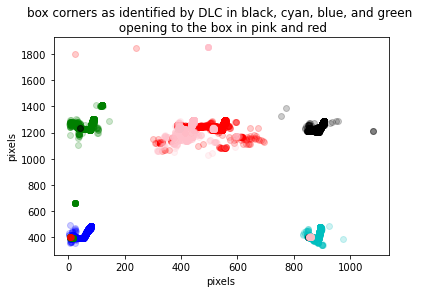

In [22]:
# let's look at the points annotated by DLC

# this plots all frames, from the first (0) to the last (-1), 
# if you want to plot a subset of frames, change a and b values

a=0
b=-1
plt.scatter(df.box_tl["x"][a:b],df.box_tl["y"][a:b],c='b',alpha=0.2)
plt.scatter(df.box_tr["x"][a:b],df.box_tr["y"][a:b],c='c',alpha=0.2)
plt.scatter(df.box_bl["x"][a:b],df.box_bl["y"][a:b],c='g',alpha=0.2)
plt.scatter(df.box_br["x"][a:b],df.box_br["y"][a:b],c='k',alpha=0.2)
plt.scatter(df.opening_bottom["x"][a:b],df.opening_bottom["y"][a:b],c='r',alpha=0.2)
plt.scatter(df.opening_top["x"][a:b],df.opening_top["y"][a:b],c='pink',alpha=0.2)
plt.xlabel('pixels')
plt.ylabel('pixels')
plt.title('box corners as identified by DLC in black, cyan, blue, and green \n opening to the box in pink and red')
plt.show()

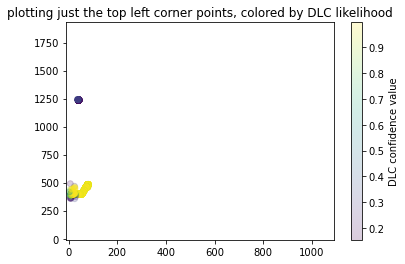

In [33]:
""" adjust your likelihood_max based on this and the following plot's data. 
you can change what you plot by as well for example, df.box_tl could be 
any column in df (box_tr, opening_top, etc.) If a particular point is not aligning or looks 'wrong'
this is a good place to test out how to change it
"""
plt.scatter(df.box_tl["x"],df.box_tl["y"],c=df.box_tl['likelihood'],alpha=0.2)
plt.xlim(-10,1090)
plt.ylim(-10,1930)
cbar=plt.colorbar()
cbar.set_label('DLC confidence value')
plt.title('plotting just the top left corner points, colored by DLC likelihood')
plt.show()

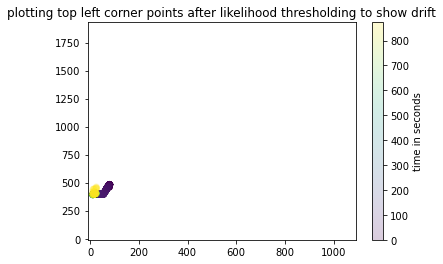

In [32]:
likelihood_max=0.9
subset_vector=df.box_tl.likelihood>likelihood_max

plt.scatter(df.box_tl["x"][subset_vector],df.box_tl["y"][subset_vector],c=df.index[subset_vector]/FPS,alpha=0.2)
plt.xlim(-10,1090)
plt.ylim(-10,1930)
cbar=plt.colorbar()
cbar.set_label('time in seconds')
plt.title('plotting top left corner points after likelihood thresholding to show drift')
plt.show()

from this, we see that a likelihood_max value of 0.9 is removing obviously wrong values, while allowing the camera drift to still be captured

In [ ]:
# let's get some data to plot from the dataframe, a warning may appear, you can ignore it
s = df.box_tl["x"].copy()
for idx in np.arange(0,len(s)):
    if df.box_tl.likelihood[idx]<likelihood_max:
        s[idx]=np.nan

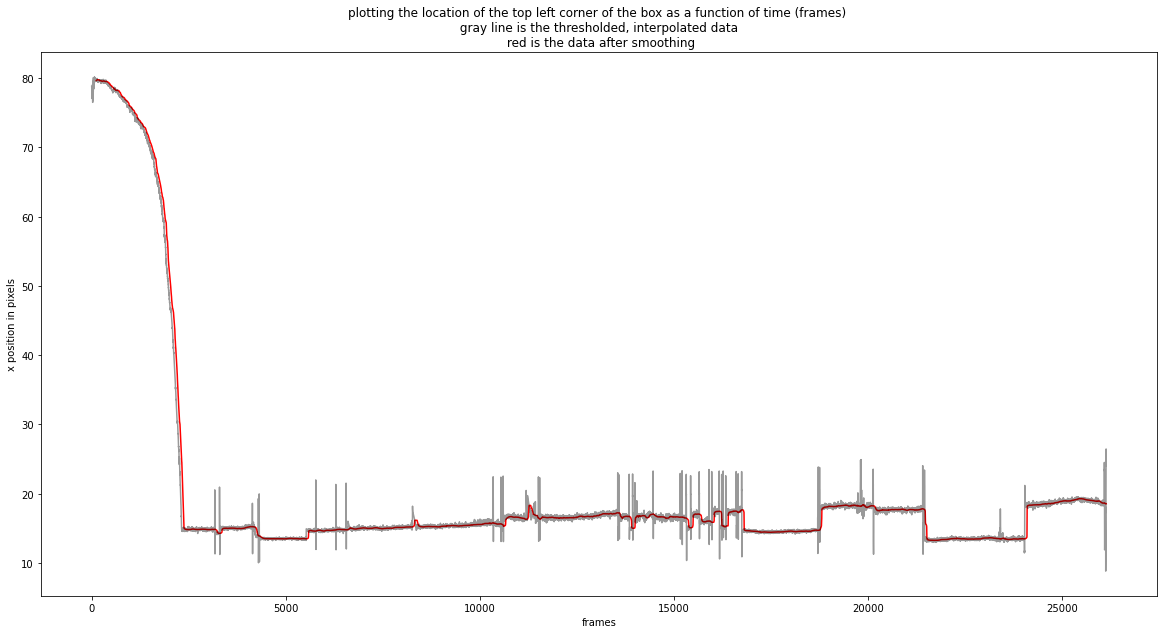

In [43]:
plt.figure(figsize=(20,10))
plt.plot(s.interpolate().rolling(4*30).median(),c='r')
plt.plot(s,c='k',alpha=0.4)
plt.title('plotting the location of the top left corner of the box as a function of time (frames) \n gray line is the thresholded, interpolated data \n red is the data after smoothing')
plt.xlabel('frames')
plt.ylabel('x position in pixels')
plt.show()

the above plot shows us that the camera field of view 'slides' about 70 pixels within the first 3000 frames, and then jitters a bit. These jitters are usually when the camera re-focuses, and deviations are quite small (< 10 pixels in a 1080x1920 pixel image)

In [45]:
# now that we have some idea of what values to use, let's apply this to the whole data frame 
# using our function reformat_df()
# this can take some time, but you should see printed statements regularly. 
new_df=reformat_df(df,0.9,1000,15,4,30)

bodyparts
box_bl
on 0 of 26128
on 100 of 26128
on 200 of 26128
on 300 of 26128
on 400 of 26128
on 500 of 26128
on 600 of 26128
on 700 of 26128
on 800 of 26128
on 900 of 26128
on 1000 of 26128
on 1100 of 26128
on 1200 of 26128
on 1300 of 26128
on 1400 of 26128
on 1500 of 26128
on 1600 of 26128
on 1700 of 26128
on 1800 of 26128
on 1900 of 26128
on 2000 of 26128
on 2100 of 26128
on 2200 of 26128
on 2300 of 26128
on 2400 of 26128
on 2500 of 26128
on 2600 of 26128
on 2700 of 26128
on 2800 of 26128
on 2900 of 26128
on 3000 of 26128
on 3100 of 26128
on 3200 of 26128
on 3300 of 26128
on 3400 of 26128
on 3500 of 26128
on 3600 of 26128
on 3700 of 26128


C:\Users\dennise\AppData\Local\Temp\ipykernel_18168\1752698965.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df=reformat_df(df,0.9,1000,15,4,30)


on 3800 of 26128
on 3900 of 26128
on 4000 of 26128
on 4100 of 26128
on 4200 of 26128
on 4300 of 26128
on 4400 of 26128
on 4500 of 26128
on 4600 of 26128
on 4700 of 26128
on 4800 of 26128
on 4900 of 26128
on 5000 of 26128
on 5100 of 26128
on 5200 of 26128
on 5300 of 26128
on 5400 of 26128
on 5500 of 26128
on 5600 of 26128
on 5700 of 26128
on 5800 of 26128
on 5900 of 26128
on 6000 of 26128
on 6100 of 26128
on 6200 of 26128
on 6300 of 26128
on 6400 of 26128
on 6500 of 26128
on 6600 of 26128
on 6700 of 26128
on 6800 of 26128
on 6900 of 26128
on 7000 of 26128
on 7100 of 26128
on 7200 of 26128
on 7300 of 26128
on 7400 of 26128
on 7500 of 26128
on 7600 of 26128
on 7700 of 26128
on 7800 of 26128
on 7900 of 26128
on 8000 of 26128
on 8100 of 26128
on 8200 of 26128
on 8300 of 26128
on 8400 of 26128
on 8500 of 26128
on 8600 of 26128
on 8700 of 26128
on 8800 of 26128
on 8900 of 26128
on 9000 of 26128
on 9100 of 26128
on 9200 of 26128
on 9300 of 26128
on 9400 of 26128
on 9500 of 26128
on 9600 of 261

C:\Users\dennise\Anaconda3\envs\fieldwork_2021\lib\site-packages\pandas\core\generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


on 2900 of 26128
on 3000 of 26128
on 3100 of 26128
on 3200 of 26128
on 3300 of 26128
on 3400 of 26128
on 3500 of 26128
on 3600 of 26128
on 3700 of 26128
on 3800 of 26128
on 3900 of 26128
on 4000 of 26128
on 4100 of 26128
on 4200 of 26128
on 4300 of 26128
on 4400 of 26128
on 4500 of 26128
on 4600 of 26128
on 4700 of 26128
on 4800 of 26128
on 4900 of 26128
on 5000 of 26128
on 5100 of 26128
on 5200 of 26128
on 5300 of 26128
on 5400 of 26128
on 5500 of 26128
on 5600 of 26128
on 5700 of 26128
on 5800 of 26128
on 5900 of 26128
on 6000 of 26128
on 6100 of 26128
on 6200 of 26128
on 6300 of 26128
on 6400 of 26128
on 6500 of 26128
on 6600 of 26128
on 6700 of 26128
on 6800 of 26128
on 6900 of 26128
on 7000 of 26128
on 7100 of 26128
on 7200 of 26128
on 7300 of 26128
on 7400 of 26128
on 7500 of 26128
on 7600 of 26128
on 7700 of 26128
on 7800 of 26128
on 7900 of 26128
on 8000 of 26128
on 8100 of 26128
on 8200 of 26128
on 8300 of 26128
on 8400 of 26128
on 8500 of 26128
on 8600 of 26128
on 8700 of 261

on 23400 of 26128
on 23500 of 26128
on 23600 of 26128
on 23700 of 26128
on 23800 of 26128
on 23900 of 26128
on 24000 of 26128
on 24100 of 26128
on 24200 of 26128
on 24300 of 26128
on 24400 of 26128
on 24500 of 26128
on 24600 of 26128
on 24700 of 26128
on 24800 of 26128
on 24900 of 26128
on 25000 of 26128
on 25100 of 26128
on 25200 of 26128
on 25300 of 26128
on 25400 of 26128
on 25500 of 26128
on 25600 of 26128
on 25700 of 26128
on 25800 of 26128
on 25900 of 26128
on 26000 of 26128
on 26100 of 26128
interp x
roll x
interp y
roll y
box_tr
on 0 of 26128
on 100 of 26128
on 200 of 26128
on 300 of 26128
on 400 of 26128
on 500 of 26128
on 600 of 26128
on 700 of 26128
on 800 of 26128
on 900 of 26128
on 1000 of 26128
on 1100 of 26128
on 1200 of 26128
on 1300 of 26128
on 1400 of 26128
on 1500 of 26128
on 1600 of 26128
on 1700 of 26128
on 1800 of 26128
on 1900 of 26128
on 2000 of 26128
on 2100 of 26128
on 2200 of 26128
on 2300 of 26128
on 2400 of 26128
on 2500 of 26128
on 2600 of 26128
on 2700 of

on 18200 of 26128
on 18300 of 26128
on 18400 of 26128
on 18500 of 26128
on 18600 of 26128
on 18700 of 26128
on 18800 of 26128
on 18900 of 26128
on 19000 of 26128
on 19100 of 26128
on 19200 of 26128
on 19300 of 26128
on 19400 of 26128
on 19500 of 26128
on 19600 of 26128
on 19700 of 26128
on 19800 of 26128
on 19900 of 26128
on 20000 of 26128
on 20100 of 26128
on 20200 of 26128
on 20300 of 26128
on 20400 of 26128
on 20500 of 26128
on 20600 of 26128
on 20700 of 26128
on 20800 of 26128
on 20900 of 26128
on 21000 of 26128
on 21100 of 26128
on 21200 of 26128
on 21300 of 26128
on 21400 of 26128
on 21500 of 26128
on 21600 of 26128
on 21700 of 26128
on 21800 of 26128
on 21900 of 26128
on 22000 of 26128
on 22100 of 26128
on 22200 of 26128
on 22300 of 26128
on 22400 of 26128
on 22500 of 26128
on 22600 of 26128
on 22700 of 26128
on 22800 of 26128
on 22900 of 26128
on 23000 of 26128
on 23100 of 26128
on 23200 of 26128
on 23300 of 26128
on 23400 of 26128
on 23500 of 26128
on 23600 of 26128
on 23700 o

on 14100 of 26128
on 14200 of 26128
on 14300 of 26128
on 14400 of 26128
on 14500 of 26128
on 14600 of 26128
on 14700 of 26128
on 14800 of 26128
on 14900 of 26128
on 15000 of 26128
on 15100 of 26128
on 15200 of 26128
on 15300 of 26128
on 15400 of 26128
on 15500 of 26128
on 15600 of 26128
on 15700 of 26128
on 15800 of 26128
on 15900 of 26128
on 16000 of 26128
on 16100 of 26128
on 16200 of 26128
on 16300 of 26128
on 16400 of 26128
on 16500 of 26128
on 16600 of 26128
on 16700 of 26128
on 16800 of 26128
on 16900 of 26128
on 17000 of 26128
on 17100 of 26128
on 17200 of 26128
on 17300 of 26128
on 17400 of 26128
on 17500 of 26128
on 17600 of 26128
on 17700 of 26128
on 17800 of 26128
on 17900 of 26128
on 18000 of 26128
on 18100 of 26128
on 18200 of 26128
on 18300 of 26128
on 18400 of 26128
on 18500 of 26128
on 18600 of 26128
on 18700 of 26128
on 18800 of 26128
on 18900 of 26128
on 19000 of 26128
on 19100 of 26128
on 19200 of 26128
on 19300 of 26128
on 19400 of 26128
on 19500 of 26128
on 19600 o

on 12200 of 26128
on 12300 of 26128
on 12400 of 26128
on 12500 of 26128
on 12600 of 26128
on 12700 of 26128
on 12800 of 26128
on 12900 of 26128
on 13000 of 26128
on 13100 of 26128
on 13200 of 26128
on 13300 of 26128
on 13400 of 26128
on 13500 of 26128
on 13600 of 26128
on 13700 of 26128
on 13800 of 26128
on 13900 of 26128
on 14000 of 26128
on 14100 of 26128
on 14200 of 26128
on 14300 of 26128
on 14400 of 26128
on 14500 of 26128
on 14600 of 26128
on 14700 of 26128
on 14800 of 26128
on 14900 of 26128
on 15000 of 26128
on 15100 of 26128
on 15200 of 26128
on 15300 of 26128
on 15400 of 26128
on 15500 of 26128
on 15600 of 26128
on 15700 of 26128
on 15800 of 26128
on 15900 of 26128
on 16000 of 26128
on 16100 of 26128
on 16200 of 26128
on 16300 of 26128
on 16400 of 26128
on 16500 of 26128
on 16600 of 26128
on 16700 of 26128
on 16800 of 26128
on 16900 of 26128
on 17000 of 26128
on 17100 of 26128
on 17200 of 26128
on 17300 of 26128
on 17400 of 26128
on 17500 of 26128
on 17600 of 26128
on 17700 o

on 6700 of 26128
on 6800 of 26128
on 6900 of 26128
on 7000 of 26128
on 7100 of 26128
on 7200 of 26128
on 7300 of 26128
on 7400 of 26128
on 7500 of 26128
on 7600 of 26128
on 7700 of 26128
on 7800 of 26128
on 7900 of 26128
on 8000 of 26128
on 8100 of 26128
on 8200 of 26128
on 8300 of 26128
on 8400 of 26128
on 8500 of 26128
on 8600 of 26128
on 8700 of 26128
on 8800 of 26128
on 8900 of 26128
on 9000 of 26128
on 9100 of 26128
on 9200 of 26128
on 9300 of 26128
on 9400 of 26128
on 9500 of 26128
on 9600 of 26128
on 9700 of 26128
on 9800 of 26128
on 9900 of 26128
on 10000 of 26128
on 10100 of 26128
on 10200 of 26128
on 10300 of 26128
on 10400 of 26128
on 10500 of 26128
on 10600 of 26128
on 10700 of 26128
on 10800 of 26128
on 10900 of 26128
on 11000 of 26128
on 11100 of 26128
on 11200 of 26128
on 11300 of 26128
on 11400 of 26128
on 11500 of 26128
on 11600 of 26128
on 11700 of 26128
on 11800 of 26128
on 11900 of 26128
on 12000 of 26128
on 12100 of 26128
on 12200 of 26128
on 12300 of 26128
on 1240

on 1600 of 26128
on 1700 of 26128
on 1800 of 26128
on 1900 of 26128
on 2000 of 26128
on 2100 of 26128
on 2200 of 26128
on 2300 of 26128
on 2400 of 26128
on 2500 of 26128
on 2600 of 26128
on 2700 of 26128
on 2800 of 26128
on 2900 of 26128
on 3000 of 26128
on 3100 of 26128
on 3200 of 26128
on 3300 of 26128
on 3400 of 26128
on 3500 of 26128
on 3600 of 26128
on 3700 of 26128
on 3800 of 26128
on 3900 of 26128
on 4000 of 26128
on 4100 of 26128
on 4200 of 26128
on 4300 of 26128
on 4400 of 26128
on 4500 of 26128
on 4600 of 26128
on 4700 of 26128
on 4800 of 26128
on 4900 of 26128
on 5000 of 26128
on 5100 of 26128
on 5200 of 26128
on 5300 of 26128
on 5400 of 26128
on 5500 of 26128
on 5600 of 26128
on 5700 of 26128
on 5800 of 26128
on 5900 of 26128
on 6000 of 26128
on 6100 of 26128
on 6200 of 26128
on 6300 of 26128
on 6400 of 26128
on 6500 of 26128
on 6600 of 26128
on 6700 of 26128
on 6800 of 26128
on 6900 of 26128
on 7000 of 26128
on 7100 of 26128
on 7200 of 26128
on 7300 of 26128
on 7400 of 261

on 22100 of 26128
on 22200 of 26128
on 22300 of 26128
on 22400 of 26128
on 22500 of 26128
on 22600 of 26128
on 22700 of 26128
on 22800 of 26128
on 22900 of 26128
on 23000 of 26128
on 23100 of 26128
on 23200 of 26128
on 23300 of 26128
on 23400 of 26128
on 23500 of 26128
on 23600 of 26128
on 23700 of 26128
on 23800 of 26128
on 23900 of 26128
on 24000 of 26128
on 24100 of 26128
on 24200 of 26128
on 24300 of 26128
on 24400 of 26128
on 24500 of 26128
on 24600 of 26128
on 24700 of 26128
on 24800 of 26128
on 24900 of 26128
on 25000 of 26128
on 25100 of 26128
on 25200 of 26128
on 25300 of 26128
on 25400 of 26128
on 25500 of 26128
on 25600 of 26128
on 25700 of 26128
on 25800 of 26128
on 25900 of 26128
on 26000 of 26128
on 26100 of 26128
tail_tip
on 0 of 26128
on 100 of 26128
on 200 of 26128
on 300 of 26128
on 400 of 26128
on 500 of 26128
on 600 of 26128
on 700 of 26128
on 800 of 26128
on 900 of 26128
on 1000 of 26128
on 1100 of 26128
on 1200 of 26128
on 1300 of 26128
on 1400 of 26128
on 1500 of

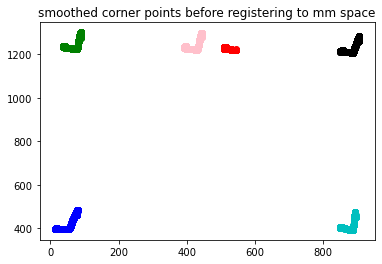

In [48]:
# let's see what this looks like: 
plt.scatter(new_df.box_bl['x'],new_df.box_bl['y'],c='g') #0,500mm
plt.scatter(new_df.box_br['x'],new_df.box_br['y'],c='k') #500,500mm
plt.scatter(new_df.box_tl['x'],new_df.box_tl['y'],c='b') #0,0mm
plt.scatter(new_df.box_tr['x'],new_df.box_tr['y'],c='c') #500,0mm

plt.scatter(new_df.opening_bottom['x'],new_df.opening_bottom['y'],c='r')
plt.scatter(new_df.opening_top['x'],new_df.opening_top['y'],c='pink')
plt.title('smoothed corner points before registering to mm space')
plt.show()

In [49]:
# save this file
new_df.to_csv(filename[:-4]+"_adj.csv")

In [50]:
# load this file (this can be skipped, but if you already have an adjusted file and
# want to start from here you can do that)
new_df = pd.read_csv(filename[:-4]+"_adj.csv",header=[0,1],index_col=0)
new_df

box_bl                              box_br                          \
               x            y likelihood           x            y likelihood   
0      88.904381  1277.683350   0.969771  904.782288  1270.714600   0.993181   
1      89.367950  1277.091858   0.963116  905.070007  1266.294739   0.981299   
2      88.979301  1277.683350   0.956444  904.782288  1262.894531   0.974830   
3      89.043297  1277.612427   0.948494  904.685394  1262.675171   0.982748   
4      89.107292  1277.541504   0.956997  904.588501  1262.455811   0.982321   
...          ...          ...        ...         ...          ...        ...   
26123  40.899511  1236.950806   0.993680  856.012146  1217.093384   0.986710   
26124  40.899118  1236.952332   0.995488  855.994080  1217.105713   0.993277   
26125  40.891485  1236.961792   0.991728  855.994080  1217.113098   0.987343   
26126  40.883327  1236.987488   0.995386  855.976135  1217.117310   0.995084   
26127  40.876135  1237.011963   0.992853  855.971863  1217.122498   0.990020   

          box_tl                             box_tr  ... paw_right_back  \
               x           y likelihood           x  ...     likelihood   
0      78.819817  461.348145   0.970968  895.608154  ...       0.196355   
1      78.710491  460.843094   0.976126  895.263245  ...       0.193503   
2      78.611977  460.760193   0.975728  895.608154  ...       0.189780   
3      78.606571  460.764847   0.976130  895.263245  ...       0.193411   
4      78.601166  460.760193   0.974672  894.918335  ...       0.170612   
...          ...         ...        ...         ...  ...            ...   
26123  18.528047  400.465332   0.987113  855.518982  ...       0.185540   
26124  18.528047  400.470581   0.995291  855.518982  ...       0.143290   
26125  18.536879  400.473343   0.982853  855.518982  ...       0.175813   
26126  18.550876  400.478653   0.996038  855.518982  ...       0.173898   
26127  18.550876  400.481979   0.996988  855.518982  ...       0.168031   

      paw_right_front                tail_base                tail_tip      \
                    x   y likelihood         x   y likelihood        x   y   
0                 NaN NaN   0.088786       NaN NaN   0.046716      NaN NaN   
1                 NaN NaN   0.064021       NaN NaN   0.050191      NaN NaN   
2                 NaN NaN   0.071854       NaN NaN   0.049670      NaN NaN   
3                 NaN NaN   0.070839       NaN NaN   0.045860      NaN NaN   
4                 NaN NaN   0.062358       NaN NaN   0.044418      NaN NaN   
...               ...  ..        ...       ...  ..        ...      ...  ..   
26123             NaN NaN   0.055303       NaN NaN   0.230045      NaN NaN   
26124             NaN NaN   0.078400       NaN NaN   0.364865      NaN NaN   
26125             NaN NaN   0.060494       NaN NaN   0.140727      NaN NaN   
26126             NaN NaN   0.085053       NaN NaN   0.216431      NaN NaN   
26127             NaN NaN   0.064808       NaN NaN   0.151017      NaN NaN   

                  
      likelihood  
0       0.373533  
1       0.295882  
2       0.311443  
3       0.314181  
4       0.285875  
...          ...  
26123   0.237289  
26124   0.255498  
26125   0.214178  
26126   0.214736  
26127   0.274145  

[26128 rows x 45 columns]

In [51]:
# next we're going to align these points to real coordinates
# we run the function aligned_df, which uses the DLC-labeled corners from each row
# and adjusts it and all other points in that line such that the corners of the box are at 0,0 0,500 500,0 and 500,500
aligned_df=align_df(new_df)
# save this dataframe 
aligned_df.to_csv(filename[:-4]+"_aligned.csv")

at 0 of 26128 rows
at 1000 of 26128 rows
at 2000 of 26128 rows
at 3000 of 26128 rows
at 4000 of 26128 rows
at 5000 of 26128 rows
at 6000 of 26128 rows
at 7000 of 26128 rows
at 8000 of 26128 rows
at 9000 of 26128 rows
at 10000 of 26128 rows
at 11000 of 26128 rows
at 12000 of 26128 rows
at 13000 of 26128 rows
at 14000 of 26128 rows
at 15000 of 26128 rows
at 16000 of 26128 rows
at 17000 of 26128 rows
at 18000 of 26128 rows
at 19000 of 26128 rows
at 20000 of 26128 rows
at 21000 of 26128 rows
at 22000 of 26128 rows
at 23000 of 26128 rows
at 24000 of 26128 rows
at 25000 of 26128 rows
at 26000 of 26128 rows


In [52]:
# load this file (this can be skipped, but if you already have an aligned file and want to start
# from here, you can do that)
aligned_df=pd.read_csv(filename[:-4]+"_aligned.csv",index_col=0,header=[0,1])

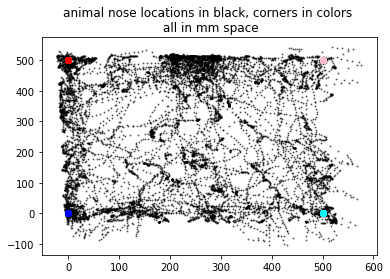

In [124]:
# next, let's see what our data look like now that it's in mm space
plt.scatter(aligned_df.nose['x'],aligned_df.nose['y'],c='k',s=1,alpha=0.5)
plt.scatter(aligned_df.box_bl['x'],aligned_df.box_bl['y'],c='r')
plt.scatter(aligned_df.box_br['x'],aligned_df.box_br['y'],c='pink')
plt.scatter(aligned_df.box_tl['x'],aligned_df.box_tl['y'],c='b')
plt.scatter(aligned_df.box_tr['x'],aligned_df.box_tr['y'],c='cyan')
plt.title('animal nose locations in black, corners in colors \n all in mm space')
plt.show()

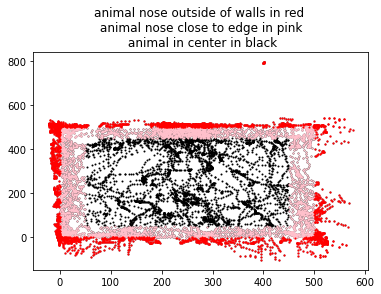

In [60]:
# let's look at the data again, but look to see when the animal is in the center of the box, close to the sides, or outside the box
plt.scatter(aligned_df.nose.x,aligned_df.nose.y,s=1,c='k')
plt.scatter(aligned_df.nose.x[aligned_df.nose.x<50],aligned_df.nose.y[aligned_df.nose.x<50],c='pink',s=1)

plt.scatter(aligned_df.nose.x[aligned_df.nose.x>450],aligned_df.nose.y[aligned_df.nose.x>450],c='pink',s=1)

plt.scatter(aligned_df.nose.x[aligned_df.nose.y<50],aligned_df.nose.y[aligned_df.nose.y<50],c='pink',s=1)
plt.scatter(aligned_df.nose.x[aligned_df.nose.y>450],aligned_df.nose.y[aligned_df.nose.y>450],c='pink',s=1)

plt.scatter(aligned_df.nose.x[aligned_df.nose.x<0],aligned_df.nose.y[aligned_df.nose.x<0],c='r',s=1)
plt.scatter(aligned_df.nose.x[aligned_df.nose.x>500],aligned_df.nose.y[aligned_df.nose.x>500],c='r',s=1)
plt.scatter(aligned_df.nose.x[aligned_df.nose.y<0],aligned_df.nose.y[aligned_df.nose.y<0],c='r',s=1)
plt.scatter(aligned_df.nose.x[aligned_df.nose.y>500],aligned_df.nose.y[aligned_df.nose.y>500],c='r',s=1)
#plt.xlim([-100,600])
#plt.ylim([-100,600])
plt.title('animal nose outside of walls in red \n animal nose close to edge in pink \n animal in center in black')
plt.show()

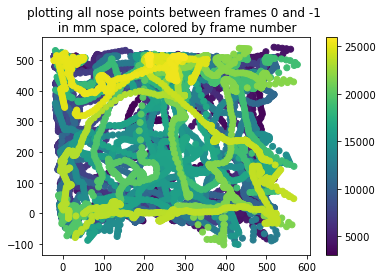

In [123]:
a=0
b=-1
plt.scatter(aligned_df.nose.x[a:b],aligned_df.nose.y[a:b],c=aligned_df.index[a:b])
plt.title('plotting all nose points between frames {} and {} \n in mm space, colored by frame number'.format(a,b))
plt.colorbar()
plt.show()

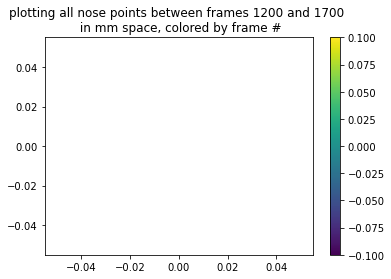

In [121]:
a=1200
b=1700
plt.title('plotting all nose points between frames {} and {} \n in mm space, colored by frame #'.format(a,b))
plt.scatter(aligned_df.nose.x[a:b],aligned_df.nose.y[a:b],c=aligned_df.index[a:b])
plt.colorbar()
plt.show()

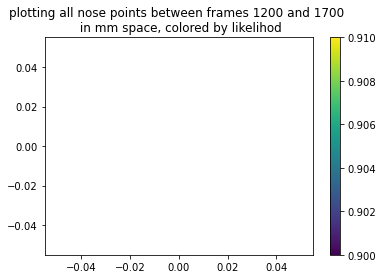

In [122]:
a=1200
b=1700
# here we see that there's some extra points between 1290 and 1310 labeled as nose that are unlikely to be the nose
# let's look at the likelihood values:
plt.scatter(aligned_df.nose.x[a:b],aligned_df.nose.y[a:b],c=aligned_df.nose.likelihood[a:b])
plt.title('plotting all nose points between frames {} and {} \n in mm space, colored by likelihod'.format(a,b))
plt.clim(.9,.91)
plt.colorbar()
plt.show()

In [111]:
# a single point was found, around 1294 frames in,
# then the rolling median filled in some additional points
# let's look at the actual data
aligned_df.nose[1290:1320]

,x,y,likelihood
1290,NaN,NaN,0.441481
1291,NaN,NaN,0.382421
1292,NaN,NaN,0.396207
1293,NaN,NaN,0.690392
1294,401.068207,793.175049,0.956210
1295,400.987885,792.976013,0.192126
1296,400.904297,792.809021,0.407619
1297,400.816345,792.696350,0.324221
1298,400.724945,792.548706,0.297638
1299,400.644714,792.375427,0.253625


In [108]:
# this is early on in the video, and could be the first labeled nose point
# if so, adding up all of the nose's x positions will give us a 0
print(np.sum(aligned_df.nose.x[0:1290]))

0.0


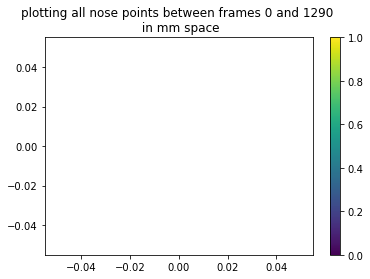

In [119]:
a=0
b=1290
# and plotting before 1290 should show no points
plt.title('plotting all nose points between frames {} and {} \n in mm space'.format(a,b))
plt.scatter(aligned_df.nose.x[a:b],aligned_df.nose.y[a:b],c='k')
plt.colorbar()
plt.show()

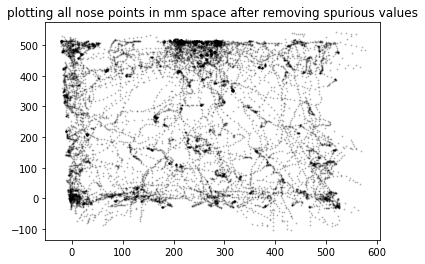

In [116]:
# so we can remove this point and re-run our align script, or just remove these nose points entirely
# I'm going to go with the latter
aligned_df.nose.x[0:1390]=np.nan
aligned_df.nose.y[0:1390]=np.nan
a=0
b=-1
plt.scatter(aligned_df.nose.x[a:b],aligned_df.nose.y[a:b],c='k',alpha=0.2,s=1)
plt.title('plotting all nose points in mm space after removing spurious values')
plt.show()

In [125]:
# let's save over the file now that we've corrected these values
aligned_df.to_csv(filename[:-4]+"_aligned.csv")

In [129]:
frames_with_nose=[]
frames_with_head=[]
frames_with_body=[]
l_frames=[]
frames_within_50mm=[]
fraction_frames_within_50mm=[]
fraction_LIGHT_frames_within_50mm=[]
fraction_LIGHT_frames_in_center=[]
first_frame_in_center=[]
num_entrances=[]
total_frames=[]
num_jumps=[]
num_rears=[]
num_frames_jumping=[]
num_frames_rearing=[]
first_nose_in_box=[]
first_head_in_box=[]
first_body_in_box=[]
sum_dist=[]
sum_dist_without_jumps=[]

# let's generate some summary data
nose_vals = ~np.isnan(aligned_df.nose['x'])
ear_l_vals = ~np.isnan(aligned_df.ear_left['x'])
ear_r_vals = ~np.isnan(aligned_df.ear_right['x'])
tail_vals = ~np.isnan(aligned_df.tail_base['x'])

# make a subset of just the location (x,y) and prediction value
#(likelihood) of the animal's nose
nose_df=aligned_df.nose
nose_df['within50mm']=0
for idx in nose_df.index:
                xval=nose_df.x[idx]
                yval=nose_df.y[idx]
                if xval < 50 or xval > 450 or yval < 50 or yval > 450:
                    nose_df.iloc[idx,3]=1 #3 is the column we're filling with ones
                    #if and only if the points are outside the box

            # get some summary data: # of frames with the nose in?
            # nose + ears (aka head)? nose + ears + tailbase? (aka body)
            # I chose these points because the paws and tail tip aren't always
            # picked up as well by DLC, so these are high-fidelity pts
frames_with_nose.append(np.sum(nose_vals))
# if the nose entered the box, find the first entrance frame, else: nan
if frames_with_nose[-1]>0:
                first_nose_in_box.append(np.argmax(nose_vals))
else:
                first_nose_in_box.append(np.argmax(nose_vals))
frames_with_head.append(np.sum(nose_vals*ear_l_vals*ear_r_vals))
# if the HEAD entered the box, find the first entrance frame, else: nan
if frames_with_head[-1]>0:
                first_head_in_box.append(np.argmax(nose_vals*ear_l_vals*ear_r_vals))
else:
                first_head_in_box.append(np.nan)
# if the BODY entered the box, find the first entrance frame, else: nan
frames_with_body.append(np.sum(nose_vals*ear_l_vals*ear_r_vals*tail_vals))
if frames_with_body[-1]>0:
                first_body_in_box.append(np.argmax(nose_vals*ear_l_vals*ear_r_vals*tail_vals))
else:
                first_body_in_box.append(np.nan)
total_frames.append(len(nose_vals))

# let's generate some more summary data:
nose_sum=np.sum(nose_vals)
summed_val=np.sum(nose_df.within50mm)
# how many frames are within 50mm of the edges of the box? (inluding
# those outside the edges which are jumps or rears)
frames_within_50mm.append(summed_val)
fraction_frames_within_50mm.append(summed_val/len(nose_df))
fraction_LIGHT_frames_in_center.append((nose_sum-summed_val)/nose_sum)
fraction_LIGHT_frames_within_50mm.append(summed_val/nose_sum)
sub_nose_df=nose_df[~np.isnan(nose_df.x)]
sub_nose_df=sub_nose_df[sub_nose_df.within50mm<1]
try:
                first_frame_in_center.append(sub_nose_df.index[0])
except:
                first_frame_in_center.append(np.nan)
# add 2 cols to df: one for if the animal was in box or not, and one for
#the "bout number" which gives us # of entrances
# also keep track of inter-bout-intervals
aligned_df['in_box']=float(0)
aligned_df['light_bout_num']=float(0)
inter_light_interval=np.zeros(len(aligned_df))
inter_light_bout=0
bout_num=0
for idx in aligned_df.index:
                if np.isnan(aligned_df.nose.x[idx]):
                    aligned_df.iloc[idx,-2]=0
                    aligned_df.iloc[idx,-1]=0
                    if aligned_df.iloc[idx-1,-2]>0:
                        inter_light_bout+=1
                    inter_light_interval[idx]=inter_light_bout
                elif aligned_df.iloc[idx-1,-2]==0:
                    bout_num+=1
                    aligned_df.iloc[idx,-2]=1
                    aligned_df.iloc[idx,-1]=bout_num
                else:
                    aligned_df.iloc[idx,-2]=1
                    aligned_df.iloc[idx,-1]=bout_num
num_entrances.append(np.max(aligned_df.light_bout_num))


C:\Users\dennise\AppData\Local\Temp\ipykernel_18168\1005842811.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nose_df['within50mm']=0
C:\Users\dennise\Anaconda3\envs\fieldwork_2021\lib\site-packages\pandas\core\computation\expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(


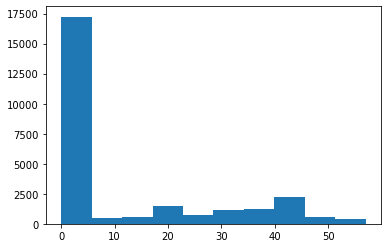

In [130]:
# plot inter light bout histogram
plt.hist(inter_light_interval)#
#plt.savefig(os.path.join('..','data','results',sub_file_name+"_inter_light_bout_hist.png"))
plt.show()

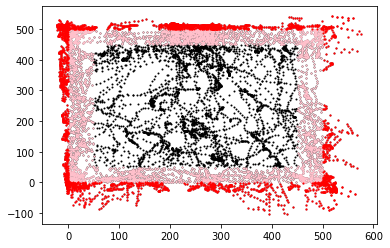

In [132]:
plt.scatter(nose_df.x,nose_df.y,s=1,c='k')
plt.scatter(nose_df.x[nose_df.x<50],nose_df.y[nose_df.x<50],c='pink',s=1)
plt.scatter(nose_df.x[nose_df.x>450],nose_df.y[nose_df.x>450],c='pink',s=1)
plt.scatter(nose_df.x[nose_df.y<50],nose_df.y[nose_df.y<50],c='pink',s=1)
plt.scatter(nose_df.x[nose_df.y>450],nose_df.y[nose_df.y>450],c='pink',s=1)
plt.scatter(nose_df.x[nose_df.x<0],nose_df.y[nose_df.x<0],c='r',s=1)
plt.scatter(nose_df.x[nose_df.x>500],nose_df.y[nose_df.x>500],c='r',s=1)
plt.scatter(nose_df.x[nose_df.y<0],nose_df.y[nose_df.y<0],c='r',s=1)
plt.scatter(nose_df.x[nose_df.y>500],nose_df.y[nose_df.y>500],c='r',s=1)            
#plt.savefig(os.path.join('..','data','results',sub_file_name+"_all-points_color_within50mm.png"))


In [134]:
# get distances between animal's body points THIS CAN TAKE A WHILE (minutes on a laptop)

aligned_df['dists','nose_midpoint_entrance']=float(0)
aligned_df['dists','nose_ear_right']=float(0)
aligned_df['dists','nose_ear_left']=float(0)
aligned_df['dists','nose_paw_left_back']=float(0)
aligned_df['dists','nose_paw_left_front']=float(0)
aligned_df['dists','nose_paw_right_back']=float(0)
aligned_df['dists','nose_paw_right_front']=float(0)
aligned_df['dists','nose_tail_tip']=float(0)
aligned_df['dists','nose_tail_base']=float(0)
aligned_df['speed']=float(0)
nanmean_xs=np.zeros(len(aligned_df))
nanmean_ys=np.zeros(len(aligned_df))
animal_dist_traveled=np.zeros(len(aligned_df))
entrance_x=np.nanmean([np.nanmedian(aligned_df.opening_top.x),np.nanmedian(aligned_df.opening_bottom.x[idx])])
entrance_y=np.nanmean([np.nanmedian(aligned_df.opening_top.y),np.nanmedian(aligned_df.opening_bottom.y[idx])])
ind_idx=-1
for idx in aligned_df.index:
                ind_idx+=1
                rel_idx = idx-aligned_df.index[0]
                nanmean_xs[ind_idx]=np.nanmean(
                        [aligned_df.nose.x[idx],
                        aligned_df.ear_left.x[idx],
                        aligned_df.ear_right.x[idx],
                        aligned_df.tail_base.x[idx]])
                nanmean_ys[ind_idx]=np.nanmean(
                        [aligned_df.nose.y[idx],
                        aligned_df.ear_left.y[idx],
                        aligned_df.ear_right.y[idx],
                        aligned_df.tail_base.y[idx]])
                if rel_idx > 0:
                    speed = np.abs(math.dist([nanmean_xs[ind_idx],nanmean_ys[ind_idx]],[nanmean_xs[ind_idx-1],nanmean_ys[ind_idx-1]]))
                else:
                    speed=0
                animal_dist_traveled[ind_idx]=speed
                aligned_df.iloc[rel_idx,-1]=speed
                aligned_df.iloc[rel_idx,-2]=math.dist([aligned_df.nose.x[idx],aligned_df.nose.y[idx]],[aligned_df.tail_base.x[idx],aligned_df.tail_base.y[idx]])
                aligned_df.iloc[rel_idx,-3]=math.dist([aligned_df.nose.x[idx],aligned_df.nose.y[idx]],[aligned_df.tail_tip.x[idx],aligned_df.tail_tip.y[idx]])
                aligned_df.iloc[rel_idx,-4]=math.dist([aligned_df.nose.x[idx],aligned_df.nose.y[idx]],[aligned_df.paw_right_front.x[idx],aligned_df.paw_right_front.y[idx]])
                aligned_df.iloc[rel_idx,-5]=math.dist([aligned_df.nose.x[idx],aligned_df.nose.y[idx]],[aligned_df.paw_right_back.x[idx],aligned_df.paw_right_back.y[idx]])
                aligned_df.iloc[rel_idx,-6]=math.dist([aligned_df.nose.x[idx],aligned_df.nose.y[idx]],[aligned_df.paw_left_front.x[idx],aligned_df.paw_left_front.y[idx]])
                aligned_df.iloc[rel_idx,-7]=math.dist([aligned_df.nose.x[idx],aligned_df.nose.y[idx]],[aligned_df.paw_left_back.x[idx],aligned_df.paw_left_back.y[idx]])
                aligned_df.iloc[rel_idx,-8]=math.dist([aligned_df.nose.x[idx],aligned_df.nose.y[idx]],[aligned_df.ear_left.x[idx],aligned_df.ear_left.y[idx]])
                aligned_df.iloc[rel_idx,-9]=math.dist([aligned_df.nose.x[idx],aligned_df.nose.y[idx]],[aligned_df.ear_right.x[idx],aligned_df.ear_right.y[idx]])
                aligned_df.iloc[rel_idx,-10]=math.dist([aligned_df.nose.x[idx],aligned_df.nose.y[idx]],[entrance_x,entrance_y])
aligned_df['inter_light_bout']=inter_light_interval
aligned_df['nanmean_x']=nanmean_xs
aligned_df['nanmean_y']=nanmean_ys
aligned_df['animal_dist_traveled']=animal_dist_traveled
#aligned_df.to_csv(os.path.join('..','data','results',sub_file_name+"_aligned_dists.csv"))

C:\Users\dennise\AppData\Local\Temp\ipykernel_18168\1135299017.py:22: RuntimeWarning: Mean of empty slice
  nanmean_xs[ind_idx]=np.nanmean(
C:\Users\dennise\AppData\Local\Temp\ipykernel_18168\1135299017.py:27: RuntimeWarning: Mean of empty slice
  nanmean_ys[ind_idx]=np.nanmean(


In [135]:
# load aligned_dists file if you want to start notebook from here 
#aligned_df = pd.read_csv(os.path.join('..','data','results',sub_file_name+"_aligned_dists.csv"),header=[0,1])

In [136]:
df_for_prediction=pd.concat([aligned_df['nose']['x'],aligned_df['nose','y'],aligned_df['nose']['likelihood'],aligned_df['tail_base']['likelihood'],aligned_df['paw_left_back']['likelihood'],aligned_df['paw_right_back']['likelihood'],aligned_df['dists']['nose_midpoint_entrance'],aligned_df['dists']['nose_tail_base'],aligned_df['speed']],axis=1)
df_for_prediction.columns=['nose_x','nose_y','nose_likelihood','tail_base_likelihood','paw_lb_likelihood','paw_rb_likelihood','dists_fromentrance','dists_nose_tail_base','speed']
try:
                cols=aligned_df.animal_dist_traveled.columns[0]
                animal_dist_traveled=aligned_df.animal_dist_traveled[cols]
except:
                animal_dist_traveled=aligned_df['animal_dist_traveled']

In [140]:
# load classifier, trained_file is a variable defined in User Inputs
clf = joblib.load(trained_file)
preds_to_plot=clf.predict(df_for_prediction.fillna(0))

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished


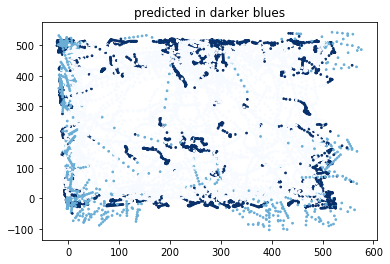

In [150]:
plt.scatter(aligned_df.nose.x,aligned_df.nose.y,c=preds_to_plot,cmap="Blues",s=3)
plt.clim([0,2])
plt.title('predicted in darker blues')
#plt.savefig(os.path.join('..','data','results',sub_file_name+'_predicted_jumps.png'))
plt.show()

In [153]:
# now let's get some summary data based on the predictions 
jump_bouts = np.zeros(len(preds_to_plot))
jump_bout_num=0
rear_bouts = np.zeros(len(preds_to_plot))
rear_bout_num=0

for idx in np.arange(4,len(preds_to_plot)):
                if preds_to_plot[idx]==1:
                    if 1 not in np.unique(preds_to_plot[idx-4:idx]):
                        jump_bout_num+=1
                    jump_bouts[idx]=jump_bout_num
                elif preds_to_plot[idx]==2:
                    if 2 not in np.unique(preds_to_plot[idx-4:idx]):
                        rear_bout_num+=1
                    rear_bouts[idx]=rear_bout_num

# now remove jumps that don't have at least 4 frames
# and get inter-jump-bouts
vals_to_rm=[]
rear_vals_to_rm=[]
animal_dist_traveled_without_jumps=np.abs(animal_dist_traveled.copy())
jump_bouts_list=list(jump_bouts)
rear_bouts_list=list(rear_bouts)
inter_jump_bout_num=0
inter_jump_bouts=np.zeros(len(preds_to_plot))
for val in np.unique(rear_bouts):
                if rear_bouts_list.count(val) < 4:
                    rear_vals_to_rm.append(val)
for idx in np.arange(0,len(rear_bouts)):
                if rear_bouts[idx] in rear_vals_to_rm:
                    rear_bouts[idx]=0

for val in np.unique(jump_bouts):
                if jump_bouts_list.count(val) < 4:
                    vals_to_rm.append(val)
for idx in np.arange(0,len(jump_bouts)):
                if jump_bouts[idx] in vals_to_rm:
                    jump_bouts[idx]=0
                    animal_dist_traveled_without_jumps[idx]=0
                if idx < len(jump_bouts)-1 and jump_bouts[idx]>0:
                    if jump_bouts[idx+1]==0:
                        inter_jump_bout_num+=1
                    else:
                        inter_jump_bouts[idx]=inter_jump_bout_num

# get the number of unique 4+ length jumps
num_jumps.append(len(np.unique(jump_bouts)))
num_rears.append(len(np.unique(rear_bouts)))
num_frames_jumping.append(len(jump_bouts[jump_bouts>0]))
num_frames_rearing.append(len(rear_bouts[rear_bouts>0]))
prediction = aligned_df.copy()
prediction['predicted_jumps']=preds_to_plot
prediction['jump_bouts']=jump_bouts
prediction['rear_bouts']=rear_bouts

# get distance traveled under different jump inclusion/exclusions
prediction['inter_jump_bouts']=inter_jump_bouts

#save out prediction csv
prediction['animal_dist_without_jumps']=animal_dist_traveled_without_jumps
sum_dist_without_jumps.append(np.sum(animal_dist_traveled_without_jumps))
sum_dist.append(np.sum(np.abs(animal_dist_traveled)))
prediction.to_csv(os.path.join('..','data','results',sub_file_name+"_predictions.csv"))

# classifier info

In [154]:
# we used manual annotations and combined them with DLC predictions into one dataframe for many videos 
all_anns=pd.read_csv('../data/all_anns.csv',header=[0,1],index_col=0)
all_anns

FileNotFoundError: [Errno 2] No such file or directory: '../data/anns/all_anns.csv'

In [155]:
df_for_training=pd.concat([all_anns['nose']['x'],all_anns['nose','y'],all_anns['nose']['likelihood'],all_anns['tail_base']['likelihood'],all_anns['paw_left_back']['likelihood'],all_anns['paw_right_back']['likelihood'],all_anns.dists.nose_midpoint_entrance,all_anns.dists['nose_tail_base'],all_anns.speed['Unnamed: 58_level_1']],axis=1)
df_for_training.columns=['nose_x','nose_y','nose_likelihood','tail_base_likelihood','paw_lb_ikelihood','paw_rb_likelihood','dists_fromentrance','dists_nose_tail_base','speed']
df_for_training_annots=all_anns.anns['Unnamed: 63_level_1']
xVar=df_for_training.columns
yVar=df_for_training_annots
df_for_training=df_for_training.fillna(0)
df_for_training.replace([np.inf, -np.inf], 0, inplace=True)

X_train, X_test, y_train, y_test = train_test_split(df_for_training, yVar, test_size=0.2)
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)

NameError: name 'all_anns' is not defined

""" we used the below code to create the Random Forest Classifier used currently, **change this cell
from Markdown to Code block and run to re-create** (it will not be identical! but will be close) """

clf = RandomForestClassifier(bootstrap=False, 
            class_weight=None, 
            criterion='gini',
            max_depth=None, 
            max_features='auto', 
            max_leaf_nodes=None,
            min_samples_leaf=1,
            min_samples_split=2, 
            min_weight_fraction_leaf=0.0,
            n_estimators=100, 
            n_jobs=4, 
            oob_score=False,
            random_state=0,
            verbose=1, 
            warm_start=False)


""" to save a new classifier change the name below """
joblib.dump(clf, '../data/yourclassifiernamehere.pkl') 

In [ ]:
# determining how well the classifier works 
clf.fit(X_train, y_train)

preds = clf.predict(X_test)
acc =  clf.score(X_test, y_test)
print(acc) #this is the accuracy of the model

print(list(zip(X_train, clf.feature_importances_)))
pd.crosstab(y_test, preds, rownames=['Actual Result'], colnames=['Predicted Result'])

In [ ]:
# here is one plot of the confusion matrix 
cm = pd.DataFrame(confusion_matrix(y_test, preds))
sns.heatmap(cm, annot=True, fmt='d',cmap='plasma');

In [ ]:
# here we scale the map by column and replot the confusion matrix
# this is helpful because there are more 0s than anything else
for col in cm.columns:
    cm[col]=np.divide(cm[col],np.max(cm[col]))

sns.heatmap(cm, annot=True,cmap='plasma');

In [ ]:
# here we plot all predictions
plt.scatter(all_anns.nose.x,all_anns.nose.y,c=preds_to_plot,cmap="Blues",s=5,alpha=.4)
plt.clim([0,2])
plt.title('predicted in darker blues')

In [ ]:
# here we plot all annotations
plt.scatter(all_anns.nose.x,all_anns.nose.y,c=yVar,cmap="Blues",s=5,alpha=.4)
plt.clim([0,2])
plt.title('annotated in darker blues')

In [ ]:
# here we plot all predicted jumps and annotated jumps
plt.scatter(all_anns.nose.x[preds_to_plot==1],all_anns.nose.y[preds_to_plot==1],c='y',s=8)
plt.scatter(all_anns.nose.x[yVar==1],all_anns.nose.y[yVar==1],s=8,c='c',alpha=0.2)
plt.title('predicted in yellow, ground truth in cyan')

In [ ]:
# here we plot all predicted rears and annotated rears
plt.scatter(all_anns.nose.x[preds_to_plot==2],all_anns.nose.y[preds_to_plot==2],c='y',s=8)
plt.scatter(all_anns.nose.x[yVar==2],all_anns.nose.y[yVar==2],s=8,c='c',alpha=0.2)
plt.title('predicted in yellow, ground truth in cyan')

In [ ]:
# we can list the features and their weights (higher = used more)
list(zip(X_train, clf.feature_importances_))

In [ ]:
# and can look at the decision trees 
decision_tree_num=0

plt.figure(figsize=(20,20))
_=tree.plot_tree(clf.estimators_[decision_tree_num])

In [ ]:
# to plot just part of a tree, try this:
plt.figure(figsize=(40,40))
max_depth=3
_ = tree.plot_tree(clf.estimators_[decision_tree_num], feature_names=X_train.columns,max_depth=max_depth,label='none',filled=True,impurity=False)
#plt.savefig('/Users/dennise/Desktop/DT_jumps_for_Alex_TOP{}.png'.format(max_depth))

## kmeans 

In [ ]:
# we can use the same general method to make a kmeans classifier
# first let's see how many neighbors are useful for our data
for n in [2,3,4,5,10,20,100]:
    classifier = KNeighborsClassifier(n_neighbors=n)
    classifier.fit(X_train, y_train)
    y_pred=classifier.predict(X_test)
    acc =  classifier.score(X_test, y_test)
    print(n,acc)
    # this shows that 3 is the best fit

In [ ]:
n=3
classifier = KNeighborsClassifier(n_neighbors=n)
classifier.fit(X_train, y_train)
y_pred=classifier.predict(X_test)
acc =  classifier.score(X_test, y_test)
print(acc)

#joblib.dump(classifier, '../data/20230216_Kmeans_jumpsrears.pkl') 
#clf = joblib.load('../data/20230216_Kmeans_jumpsrears.pkl')

In [ ]:
# and we can make the same confusion matrix
cm = pd.DataFrame(confusion_matrix(y_test, y_pred))
sns.heatmap(cm, annot=True, fmt='d',cmap='plasma');

In [ ]:
# scaled confusion matrix 
for col in cm.columns:
    cm[col]=np.divide(cm[col],np.max(cm[col]))

sns.heatmap(cm, annot=True,cmap='plasma');

In [ ]:
# predictions 
preds_to_plot=classifier.predict(df_for_training.fillna(0))
plt.scatter(df_for_training.nose_x,df_for_training.nose_y,c=preds_to_plot,cmap="Blues",alpha=.1,s=5)
plt.clim([0,2])

In [ ]:
# annotations
preds_to_plot=classifier.predict(df_for_training.fillna(0))
plt.scatter(df_for_training.nose_x,df_for_training.nose_y,c=df_for_training_annots,cmap="Blues",alpha=.1,s=5)
plt.clim([0,2])

In [ ]:
# predicted vs annotated jumps
plt.scatter(all_anns.nose.x[preds_to_plot==1],all_anns.nose.y[preds_to_plot==1],c='y',s=8)
plt.scatter(all_anns.nose.x[yVar==1],all_anns.nose.y[yVar==1],s=8,c='c',alpha=0.2)
plt.title('predicted in yellow, ground truth in cyan')

In [ ]:
# predicted vs annotated rears
plt.scatter(all_anns.nose.x[preds_to_plot==2],all_anns.nose.y[preds_to_plot==2],c='y',s=8)
plt.scatter(all_anns.nose.x[yVar==2],all_anns.nose.y[yVar==2],s=8,c='c',alpha=0.2)
plt.title('predicted in yellow, ground truth in cyan')